In [1]:
import json
import pandas as pd

from config import json_datapath, json_graphpath, csv_graphpath

In [2]:
ignore_list = ['molecule_to']

In [3]:
with open(json_datapath, 'r') as json_file:
    data = json.load(json_file)
    dao_ids = {
        dao['UID']: dao['Project Name']
        for dao in data
    }
    for dao in data:
        friends = list(set([d for d in dao['Friend IDs'] if d in dao_ids.keys()]))
        dao.update({
            "DAO Friend IDs": friends,
            "DAO Friends": [dao_ids.get(f) for f in friends]
        })
    for dao in data:
        followers = []
        for d in data:
            if dao['UID'] in d['DAO Friend IDs']:
                followers.append(d['UID'])
        dao.update({
            "DAO Follower IDs": followers,
            "DAO Followers": [dao_ids.get(f) for f in followers]
        })

In [4]:
df = pd.DataFrame(data)
df[['UID', 'Project Name', 'Twitter', 
    'DAO Friend IDs', 'DAO Friends', 
    'DAO Follower IDs', 'DAO Followers'
   ]].to_json(json_graphpath, orient='records', indent=4)

df['Logo URL'] = df['Meta Data'].apply(lambda x: x['profile_image_url'])
df['DAO Friends'] = df['DAO Friends'].str.join(', ')
df['DAO Followers'] = df['DAO Followers'].str.join(', ')

df[['UID', 'Project Name', 'Twitter', 
    'Logo URL', 'DAO Friends', 'DAO Followers'
   ]].to_csv(csv_graphpath)

df = df[~df['Twitter'].isin(ignore_list)]

len(df)

9

In [5]:
df.head()

,UID,Project Name,Twitter,Updated,Meta Data,Friend IDs,Follower IDs,DAO Friend IDs,DAO Friends,DAO Follower IDs,DAO Followers,Logo URL
0,996552749893304320,1Hive,1hiveorg,20220705-16-28,"{'id': 996552749893304320, 'id_str': '99655274...","[1237410164900151297, 1518603763073916929, 148...",[],[856446453157376003],GitcoinDAO,"[1433793310703898629, 798810763586478080]","DeveloperDAO, Giveth",http://pbs.twimg.com/profile_images/1276286557...
1,1403870329366355969,AcreDAOS,acredaos,20220705-16-29,"{'id': 1403870329366355969, 'id_str': '1403870...","[835531122519879680, 1087282265774669824, 1426...",[],"[798810763586478080, 1460801607940116486]","Giveth, All for Climate DAO","[1468747986230513677, 1460801607940116486, 765...","Aera Force, All for Climate DAO, Basin DAO",http://pbs.twimg.com/profile_images/1461360204...
2,1468747986230513677,Aera Force,aeraforce,20220705-16-29,"{'id': 1468747986230513677, 'id_str': '1468747...","[1474970797747978248, 2838643372, 102426891125...",[],"[765801233110163456, 1403870329366355969, 1460...","Basin DAO, AcreDAOS, All for Climate DAO",[],,http://pbs.twimg.com/profile_images/1509925596...
3,1460801607940116486,All for Climate DAO,all4climatedao,20220705-16-29,"{'id': 1460801607940116486, 'id_str': '1460801...","[1242354095861751810, 15830512, 13169943644350...",[],"[798810763586478080, 1403870329366355969, 8564...","Giveth, AcreDAOS, GitcoinDAO, DeveloperDAO","[1403870329366355969, 1468747986230513677, 765...","AcreDAOS, Aera Force, Basin DAO, DeveloperDAO",http://pbs.twimg.com/profile_images/1461336359...
4,765801233110163456,Basin DAO,basindao,20220705-16-29,"{'id': 765801233110163456, 'id_str': '76580123...","[1516745294028984322, 1363776067215925248, 136...",[],"[1403870329366355969, 856446453157376003, 1460...","AcreDAOS, GitcoinDAO, All for Climate DAO",[1468747986230513677],Aera Force,http://pbs.twimg.com/profile_images/1463399377...


In [6]:
from community import community_louvain
import networkx as nx

In [7]:
df = pd.DataFrame(data)
df = df[~df['Twitter'].isin(ignore_list)]

G = nx.from_dict_of_lists(df.set_index('Project Name')['DAO Friends'].to_dict())
G.remove_edges_from(nx.selfloop_edges(G))
G = nx.k_core(G, 2)
G.number_of_nodes()

8

In [8]:
degrees = pd.Series(dict(G.degree), name='Connections')
partition = pd.Series(community_louvain.best_partition(G), name="Group")
cluster_df = pd.concat([degrees, partition], axis=1)
cluster_df.head()

,Connections,Group
1Hive,3,0
AcreDAOS,4,1
Aera Force,3,1
All for Climate DAO,6,1
Basin DAO,4,1


In [9]:
colors = [
    '#02E2AC', # green
    '#FFCC00', # yellow
    '#F3587D', # red
    '#4D82C1', # blue
]
color_mapping = dict(zip(cluster_df['Group'].value_counts().index, colors))
color_mapping

{0: '#02E2AC', 1: '#FFCC00'}

## Step 3 - Format CSVs for uploading into Flourish

### Links Tab

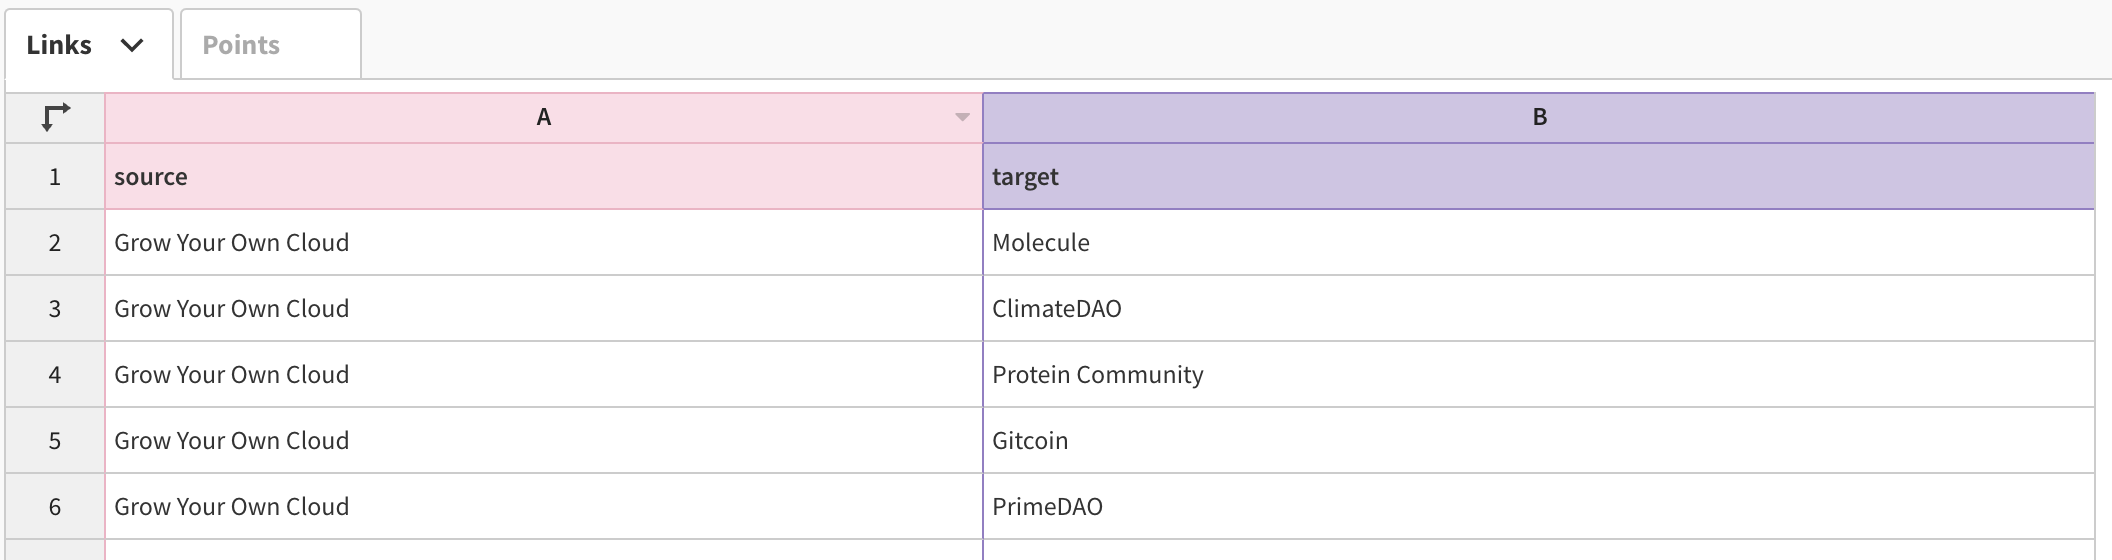

In [10]:
flourish_links = pd.DataFrame(
    G.edges(), 
    columns=['source', 'target']
)
flourish_links.head()

,source,target
0,1Hive,GitcoinDAO
1,1Hive,DeveloperDAO
2,1Hive,Giveth
3,AcreDAOS,Giveth
4,AcreDAOS,All for Climate DAO


### Points Tab

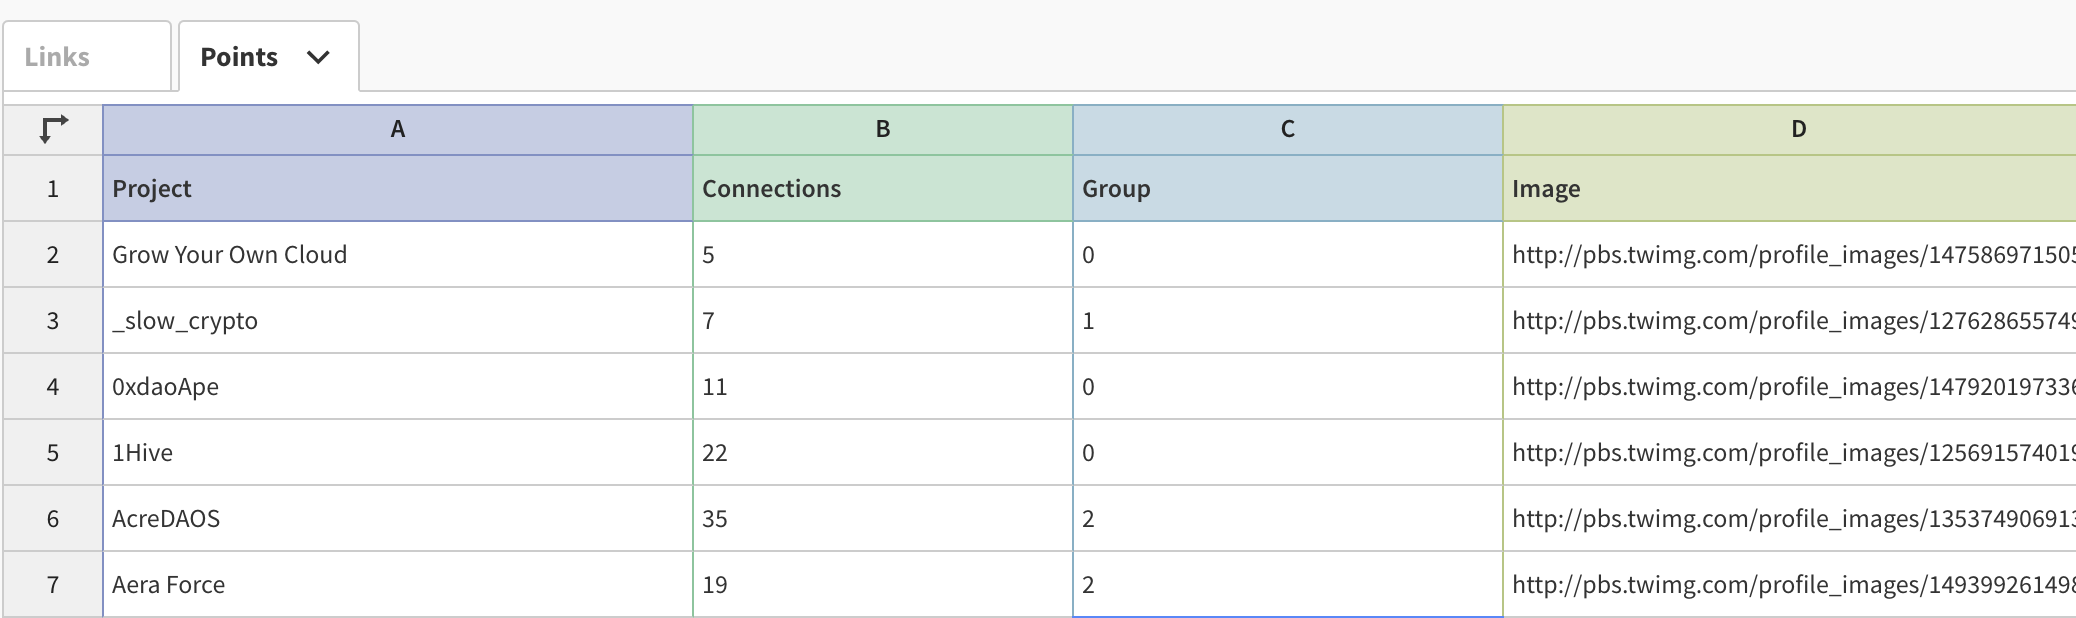

In [11]:
data_cols = ['Group', 'Connections', 'Twitter', 'Meta Data']

flourish_points = cluster_df.join(df.set_index('Project Name'))[data_cols]
flourish_points.dropna(inplace=True)
flourish_points['Image'] = flourish_points['Meta Data'].apply(lambda x: x['profile_image_url_https'])
flourish_points.index.name = 'Project'
flourish_points['Group'] = flourish_points['Group'].map(color_mapping)
flourish_points.head()

,Group,Connections,Twitter,Meta Data,Image
Project,,,,,
1Hive,#02E2AC,3,1hiveorg,"{'id': 996552749893304320, 'id_str': '99655274...",https://pbs.twimg.com/profile_images/127628655...
AcreDAOS,#FFCC00,4,acredaos,"{'id': 1403870329366355969, 'id_str': '1403870...",https://pbs.twimg.com/profile_images/146136020...
Aera Force,#FFCC00,3,aeraforce,"{'id': 1468747986230513677, 'id_str': '1468747...",https://pbs.twimg.com/profile_images/150992559...
All for Climate DAO,#FFCC00,6,all4climatedao,"{'id': 1460801607940116486, 'id_str': '1460801...",https://pbs.twimg.com/profile_images/146133635...
Basin DAO,#FFCC00,4,basindao,"{'id': 765801233110163456, 'id_str': '76580123...",https://pbs.twimg.com/profile_images/146339937...


In [12]:
def format_popup(metadata):
    
    project_name = metadata["name"]    
    screen_name = metadata['screen_name']
    
    description  = metadata['description']
    description = description.replace("\n","<br>")
    
    popup_html = "".join([
        f'<strong>{project_name}</strong>',
        ' | ',
        f'<a href="https://twitter.com/{screen_name}">@{screen_name}</a>',
        f"<p>{description} </p>"
    ])
    
    url = metadata['url']
    if url:
        url_display = metadata['entities']['url']['urls'][0]['display_url']
        popup_html += f'<a href="{url}">{url_display}</a>'
    
    return popup_html
    
flourish_points['Popup'] = flourish_points['Meta Data'].apply(format_popup)

In [13]:
flourish_points.drop(columns='Meta Data').head()

,Group,Connections,Twitter,Image,Popup
Project,,,,,
1Hive,#02E2AC,3,1hiveorg,https://pbs.twimg.com/profile_images/127628655...,"<strong>1Hive 🐝</strong> | <a href=""https://tw..."
AcreDAOS,#FFCC00,4,acredaos,https://pbs.twimg.com/profile_images/146136020...,"<strong>ACRE DAOs</strong> | <a href=""https://..."
Aera Force,#FFCC00,3,aeraforce,https://pbs.twimg.com/profile_images/150992559...,"<strong>Aera Force</strong> | <a href=""https:/..."
All for Climate DAO,#FFCC00,6,all4climatedao,https://pbs.twimg.com/profile_images/146133635...,<strong>All for Climate DAO 🌍🌱</strong> | <a h...
Basin DAO,#FFCC00,4,basindao,https://pbs.twimg.com/profile_images/146339937...,<strong>basinDAO is BUIDLing $BASIN</strong> |...


### Export as CSV files to upload into Flourish

In [14]:
flourish_links.to_csv('../data/flourish_links.csv', index = False)
flourish_points.drop(columns='Meta Data').to_csv('../data/flourish_points.csv')

# Create a Notion database

In [15]:
notion = flourish_points.copy()
notion['Twitter URL'] = notion['Twitter'].apply(lambda x: "https://twitter.com/" + x)
notion['Twitter Handle'] = notion['Twitter'].apply(lambda x: "@" + x)

notion['Description'] = notion['Meta Data'].apply(lambda x: x['description'])
notion['Webpage'] = notion['Meta Data'].apply(lambda x: 
                                              x['entities']['url']['urls'][0]['display_url'] if x['url'] else None)

notion.drop(columns=['Meta Data', 'Twitter', 'Popup'], inplace=True)
notion.reset_index(inplace=True)
notion.head()

,Project,Group,Connections,Image,Twitter URL,Twitter Handle,Description,Webpage
0,1Hive,#02E2AC,3,https://pbs.twimg.com/profile_images/127628655...,https://twitter.com/1hiveorg,@1hiveorg,A community of web3 builders,1hive.org
1,AcreDAOS,#FFCC00,4,https://pbs.twimg.com/profile_images/146136020...,https://twitter.com/acredaos,@acredaos,Autonomous Communities for Regenerative Econom...,acredaos.com
2,Aera Force,#FFCC00,3,https://pbs.twimg.com/profile_images/150992559...,https://twitter.com/aeraforce,@aeraforce,Aera Force is a VC DAO investing in our collec...,AeraForce.xyz
3,All for Climate DAO,#FFCC00,6,https://pbs.twimg.com/profile_images/146133635...,https://twitter.com/all4climatedao,@all4climatedao,Building a 21st century movement of citizens t...,dao.allforclimate.earth
4,Basin DAO,#FFCC00,4,https://pbs.twimg.com/profile_images/146339937...,https://twitter.com/basindao,@basindao,unlocking #carbon + #naturalcapital value in #...,basin.global
